In [1]:
import h5py
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import time

from dotenv import load_dotenv

from sklearn.model_selection import train_test_split

from my_functions.my_fun import *
from my_functions.my_models import vgg16,vgg16_svm
from my_functions.My_nn import My_nn

In [2]:
load_dotenv()

ASSETS_DIR = os.getenv('ASSETS_DIR')
ANOT_DIR = os.getenv('PMEMO_ANOTATIONS')
stat_anot_file = os.path.join(ANOT_DIR,'static_annotations.csv')
META_DIR = os.getenv('PMEMO_META')
aux_dir = META_DIR.split('.')[0]
META_DIR = f'{aux_dir}_total.csv'



# Cargar datos chromas magnitud

In [3]:
chromas_m = load_spectrograms(filename='chromas_magnitud')

In [4]:
chromas_m.shape

(767, 224, 224, 3)

# Preparar etiquetas

In [5]:
anot_df = pd.read_csv(stat_anot_file)
anot_df.head(10)

,musicId,Arousal(mean),Valence(mean)
0,1,0.4000,0.5750
1,4,0.2625,0.2875
2,5,0.1500,0.2000
3,6,0.5125,0.3500
4,7,0.7000,0.7250
5,8,0.3875,0.2250
6,9,0.4500,0.2875
7,10,0.4375,0.4250
8,12,0.6875,0.5750
9,13,0.8250,0.5875


In [6]:
labels = anot_df[['Arousal(mean)','Valence(mean)']].values
print(labels)
print(labels.shape)

[[0.4    0.575 ]
 [0.2625 0.2875]
 [0.15   0.2   ]
 ...
 [0.7125 0.6625]
 [0.875  0.775 ]
 [0.6625 0.575 ]]
(767, 2)


# Dividir conjunto de datos

In [7]:
pmemo_meta = pd.read_csv(META_DIR)
pmemo_meta.head(2)

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
0,1,1.mp3,Good Drank,2 Chainz,"Def Jam Presents: Direct Deposit, Vol. 2",32.10,02:35,03:05
1,4,4.mp3,X Bitch (feat. Future),21 Savage,Savage Mode,28.09,03:00,03:26


In [8]:
indices = np.arange(len(pmemo_meta))
idx = np.random.randint(0,indices.shape[0])
print(idx)
print(pmemo_meta.iloc[idx])

145
musicId                         179
fileName                    179.mp3
title                I Got the Keys
artist                    DJ Khaled
album                I Got the Keys
duration                      33.12
chorus_start_time             03:00
chorus_end_time               03:31
Name: 145, dtype: object


In [9]:
# Mezcla los índices de manera aleatoria
np.random.shuffle(indices)

# Calcula los tamaños para cada conjunto
train_size = int(0.6 * len(indices))
val_size = int(0.2 * len(indices))
test_size = len(indices) - train_size - val_size  # Para asegurar que se cubre todo

# Divide el array en entrenamiento, validación y prueba
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

print(f"Entrenamiento: {len(train_indices)}")
print(f"Validación: {len(val_indices)}")
print(f"Pruebas: {len(test_indices)}")

Entrenamiento: 460
Validación: 153
Pruebas: 154


In [10]:
X_train = []
y_train = []
for idx in train_indices:
    X_train.append(chromas_m[idx])
    y_train.append(labels[idx])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = []
y_val = []
for idx in val_indices:
    X_val.append(chromas_m[idx])
    y_val.append(labels[idx])
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = []
y_test = []
for idx in test_indices:
    X_test.append(chromas_m[idx])
    y_test.append(labels[idx])

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f'Datos de entrenamiento shape: {X_train.shape}')
print(f'Etiquetas de entrenamiento shape: {y_train.shape}')

print(f'Datos de pruebas shape: {X_test.shape}')
print(f'Etiquetas de pruebas shape: {y_test.shape}')

print(f'Datos de validación shape: {X_val.shape}')
print(f'Etiquetas de validación shape: {y_val.shape}')


Datos de entrenamiento shape: (460, 224, 224, 3)
Etiquetas de entrenamiento shape: (460, 2)
Datos de pruebas shape: (154, 224, 224, 3)
Etiquetas de pruebas shape: (154, 2)
Datos de validación shape: (153, 224, 224, 3)
Etiquetas de validación shape: (153, 2)


# Guardar datos procesados

In [11]:
# Guardar los datos en un archivo .h5
DATOS_DIR = os.path.join(ASSETS_DIR,'processed_chromas_m.h5')

with h5py.File(DATOS_DIR, 'w') as hf:
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('X_test', data=X_test)
    hf.create_dataset('X_val', data=X_val)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('y_test', data=y_test)
    hf.create_dataset('y_val', data=y_val)

In [12]:
# X_train,X_test,y_train,y_test = train_test_split(chromas_m,
#                                                  labels,
#                                                  test_size=0.4,
#                                                  random_state=43)

# X_test,X_val,y_test,y_val = train_test_split(X_test,
#                                              y_test,
#                                              test_size=0.5,
#                                              random_state=43)


# print(f'Datos de entrenamiento shape: {X_train.shape}')
# print(f'Etiquetas de entrenamiento shape: {y_train.shape}')

# print(f'Datos de pruebas shape: {X_test.shape}')
# print(f'Etiquetas de pruebas shape: {y_test.shape}')

# print(f'Datos de validación shape: {X_val.shape}')
# print(f'Etiquetas de validación shape: {y_val.shape}')

# Datos de entrenamiento shape: (460, 244, 224, 3)
# Etiquetas de entrenamiento shape: (460, 2)
# Datos de pruebas shape: (153, 244, 224, 3)
# Etiquetas de pruebas shape: (153, 2)
# Datos de validación shape: (154, 244, 224, 3)
# Etiquetas de validación shape: (154, 2)



In [13]:
X_train.shape

(460, 224, 224, 3)

# VGG16

In [14]:
modelo_vgg = vgg16(trainable=True)

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328 

In [15]:
exp = My_nn(X_train=X_train,y_train=y_train,
            X_test=X_test,y_test=y_test,
            X_val=X_val,y_val=y_val,
            model=modelo_vgg)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                             

c:\Users\leo_d\anaconda3\envs\mirtools\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [16]:
hist = exp.train()

Epoch 1/20
29/29 [==============================] - 203s 7s/step - loss: 110.0154 - mae: 2.1965 - val_loss: 0.1743 - val_mae: 0.3830
Epoch 2/20
29/29 [==============================] - 272s 9s/step - loss: 0.2306 - mae: 0.3915 - val_loss: 0.0446 - val_mae: 0.1776
Epoch 3/20
29/29 [==============================] - 236s 8s/step - loss: 0.0673 - mae: 0.2098 - val_loss: 0.0314 - val_mae: 0.1482
Epoch 4/20
29/29 [==============================] - 245s 8s/step - loss: 0.0483 - mae: 0.1786 - val_loss: 0.0337 - val_mae: 0.1572
Epoch 5/20
29/29 [==============================] - 219s 8s/step - loss: 0.0468 - mae: 0.1762 - val_loss: 0.0297 - val_mae: 0.1410
Epoch 6/20
29/29 [==============================] - 212s 7s/step - loss: 0.0443 - mae: 0.1717 - val_loss: 0.0301 - val_mae: 0.1432
Epoch 7/20
29/29 [==============================] - 213s 7s/step - loss: 0.0422 - mae: 0.1662 - val_loss: 0.0305 - val_mae: 0.1463
Epoch 8/20
29/29 [==============================] - 194s 7s/step - loss: 0.0460 -

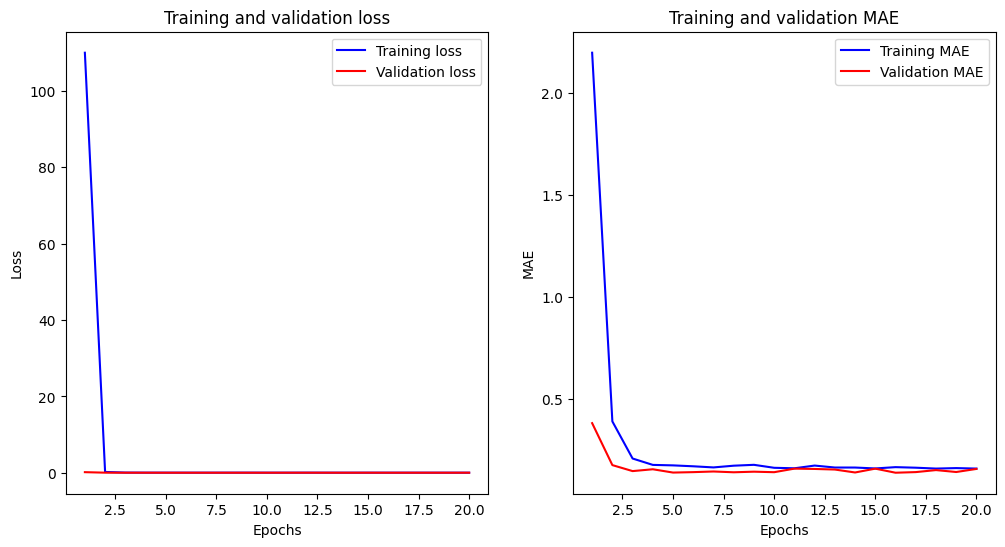

In [17]:
exp.show_loss_history(hist)

In [18]:
loss,mae = exp.evaluate()
print(loss)
print(mae)

5/5 - 16s - loss: 0.0361 - mae: 0.1615 - 16s/epoch - 3s/step
0.03609735146164894
0.1615343689918518


In [19]:
y_pred = exp.recognize()
print(y_pred.shape)

5/5 [==============================] - 16s 3s/step
(154, 2)


In [20]:
reporte = exp.get_report(y_true=y_test,y_pred=y_pred)
for k in reporte:
    print(f'{k}: {reporte[k]}')

Mean Squared Error (MSE): 0.03609735659078778
Mean Absolute Error (MAE): 0.1615343578168635
R-squared (R2): -555168.4738385638


In [21]:
print(np.sort(y_test))

[[0.6        0.65      ]
 [0.275      0.55      ]
 [0.5875     0.625     ]
 [0.7        0.7375    ]
 [0.375      0.4625    ]
 [0.475      0.525     ]
 [0.65       0.75      ]
 [0.7375     0.75      ]
 [0.6125     0.8375    ]
 [0.7125     0.7375    ]
 [0.5875     0.7125    ]
 [0.6625     0.725     ]
 [0.8125     0.95      ]
 [0.5125     0.6       ]
 [0.7375     0.9625    ]
 [0.5375     0.575     ]
 [0.725      0.7375    ]
 [0.675      0.6875    ]
 [0.65       0.7       ]
 [0.4375     0.5       ]
 [0.2875     0.3125    ]
 [0.40909091 0.42045455]
 [0.325      0.4375    ]
 [0.76136364 0.78409091]
 [0.3625     0.5625    ]
 [0.7375     0.8125    ]
 [0.7375     0.8375    ]
 [0.775      0.85      ]
 [0.5875     0.725     ]
 [0.7875     0.8625    ]
 [0.4125     0.5       ]
 [0.575      0.9       ]
 [0.725      0.75      ]
 [0.6875     0.7       ]
 [0.6375     0.825     ]
 [0.3        0.3125    ]
 [0.40909091 0.48863636]
 [0.5125     0.65      ]
 [0.55       0.6625    ]
 [0.5        0.575     ]


In [22]:
print(np.sort(y_pred))

[[0.5252003  0.54366744]
 [0.5248155  0.54322344]
 [0.52511805 0.5435988 ]
 [0.5246119  0.54285896]
 [0.5246956  0.54298323]
 [0.5245626  0.5429588 ]
 [0.524656   0.5429151 ]
 [0.52427405 0.5426104 ]
 [0.52478576 0.5431886 ]
 [0.5247932  0.5432179 ]
 [0.5245085  0.54275185]
 [0.5248533  0.5432774 ]
 [0.52460116 0.5428678 ]
 [0.52519953 0.54360974]
 [0.5245651  0.5427979 ]
 [0.5249023  0.5432291 ]
 [0.5244878  0.5428633 ]
 [0.5249543  0.54342157]
 [0.5247991  0.5432854 ]
 [0.5249161  0.5433662 ]
 [0.5248678  0.5432184 ]
 [0.52482975 0.54321635]
 [0.5247692  0.54316986]
 [0.5248963  0.5433817 ]
 [0.52458245 0.54300773]
 [0.52451724 0.54292166]
 [0.52504146 0.5434069 ]
 [0.5244464  0.54282594]
 [0.5248752  0.5433148 ]
 [0.52476877 0.5430614 ]
 [0.5249342  0.54338336]
 [0.52470046 0.54310626]
 [0.52454954 0.54292285]
 [0.52454764 0.54288316]
 [0.5250103  0.543367  ]
 [0.52480084 0.54327714]
 [0.5244746  0.54289514]
 [0.5244341  0.5428185 ]
 [0.52496773 0.54341936]
 [0.5252146  0.5436283 ]


In [23]:
exp.model_name = 'vgg16_chroma_m'
exp.save_model()